In [2]:
import torch

In [3]:
from typing import Tuple

In [4]:
# My own implementation of growing nca, following the steps described in https://distill.pub/2020/growing-ca/

In [5]:
GRID_SIZE=64
CHANNELS=8 # 8 channels: 1-3: RGB, 4: alpha, 5-8: hidden

def initialize_grid(
        start_coords: Tuple[int,int] = (GRID_SIZE // 2, GRID_SIZE // 2), # default: center 
        seed: torch.Tensor = torch.tensor([0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0], dtype=torch.float32) # default: alpha=1, hidden=1
    ):
    # 64 x 64 grid of 8-channel tensors
    state_grid = torch.zeros(GRID_SIZE, GRID_SIZE, CHANNELS, dtype=torch.float32)
    
    # set seed cell
    x,y = start_coords
    state_grid[x,y,:] = seed
    return state_grid

In [6]:
"""
Sobel filters are 3x3 kernels used to detect edges by approximating the gradient (rate of change) in the grid 
along the x and y axis.
"""
SOBEL_X = torch.tensor([ # for vertical change
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
SOBEL_X = torch.eye(CHANNELS).unsqueeze(-1).unsqueeze(-1) * SOBEL_X # [8, 8, 3, 3]

SOBEL_Y = torch.tensor([ # horizontal change
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
SOBEL_Y = torch.eye(CHANNELS).unsqueeze(-1).unsqueeze(-1) * SOBEL_Y # [8, 8, 3, 3]

# simluates the "chemical gradient"
def perceive(state_grid):
    # batch dim
    state_grid = state_grid.permute(2, 0, 1).unsqueeze(0)
    
    # slide sobel filters over the entire grid on both dimensions
    # this applies each single cells perception simultanuously
    grad_x = torch.nn.functional.conv2d(state_grid, SOBEL_X, padding=1)
    grad_y = torch.nn.functional.conv2d(state_grid, SOBEL_Y, padding=1)

    # concatenate, because we need to track each cells current state and the next state for both dimensions
    # so returned dimensions for each cell is 8+8+8 = 24
    perception_grid = torch.cat([state_grid, grad_x, grad_y], dim=1)
    return perception_grid



In [7]:
# takes in a 24d vector from the perception grid
# applies a convoultion to each cells percieved state to generate the cells new state
# the weights of the convolution kernel will be learned via backpropagation

# using convolution layers with learned kernel weights is identically to using an MLP, just faster
class UpdateRule(torch.nn.Module):
    def __init__(self):
        super(UpdateRule, self).__init__()
        self.conv1 = torch.nn.Conv2d(24, 32, 1) # 24d perception vector -> 32 hidden
        self.conv2 = torch.nn.Conv2d(32, 8, 1) # 32 hidden -> 8 output (deltas) to modify current state to new state
        torch.nn.init.zeros_(self.conv2.weight) # initial weights are 0

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x)) # ReLU activation after first conv
        x = self.conv2(x)
        return x

In [8]:
# apply a random mask to the update deltas to simulate independent cell behaviour
UPDATE_PROB=0.5

def random_masking(delta, update_prob=UPDATE_PROB):
    random_mask = (torch.rand(1, 1, GRID_SIZE, GRID_SIZE) < update_prob).float()
    delta = delta * random_mask
    return delta


# bool mask to make sure only alive cells can grow
def alive_masking(state_grid):
    # cells with alpha > 0.1 are considered alive
    alive_mask = torch.nn.functional.max_pool2d(state_grid[:, 3:4, :, :], kernel_size=3, stride=1, padding=1) > 0.1
   # convert bool mask to float and apply to all channels
    alive_mask = alive_mask.float().expand(-1, CHANNELS, -1, -1)
    alive_grid = state_grid * alive_mask
    return alive_grid

In [9]:
# putting it all together
# functio to go from current state to next state
def update(state_grid, update_rule):
    # compute percieved grid (gradient for each cell)
    perception_grid = perceive(state_grid) # [1, 24, 64, 64]
    
    # apply update rule (learned 1x1 convolution)
    delta = update_rule(perception_grid) # [1, 8, 64, 64]
    delta = random_masking(delta) # apply random mask to deltas
    
    # modify current state with the update delta to get new state
    state_grid = state_grid.permute(2, 0, 1).unsqueeze(0) # [1, 8, 64, 64]
    state_grid = state_grid + delta # apply update offset
    state_grid = alive_masking(state_grid) # apply alive mask to grid
    
    return state_grid.squeeze(0).permute(1, 2, 0) # back to [64, 64, 8]

## Training

In [10]:
import random
import matplotlib.pyplot as plt

In [90]:
%matplotlib inline
from IPython.display import clear_output, display

In [137]:
def plot_grid(fig, ax, grid, i=0):
    # Clear previous plot
    clear_output(wait=True)
    # Plot RGB channels
    ax.clear()
    ax.imshow(grid.detach().cpu().numpy()[:, :, :3])
    ax.set_title(f"Epoch {i + 1}")
    ax.axis('off')
    
    display(fig)

In [151]:
grid_states = [] # collect to animate later

# try to iteratively learn weights of the convolution kernel
# by optimizing loss function towards our target image
def training_loop(target, epochs, plot_interval, image_interval, lr=0.001):
    update_rule = UpdateRule() # the 1x1 convolution module for cell updates
    optimizer = torch.optim.Adam(update_rule.parameters(), lr=lr)
    
    loss_history = [] # to plot the loss

    fig, (ax_grid, ax_loss) = plt.subplots(1, 2, figsize=(10, 4))

    for i in range(epochs):
        cn_steps = random.randint(64, 94) # get a randomized number of simulation steps
        # get the initial grid
        grid = initialize_grid()
        
        # run the nca in training mode
        update_rule.train()
        for _ in range(cn_steps):
            grid = update(grid, update_rule)
        
        # compute the l2 loss on on RGBA channels
        # i.e. pixel-wise square difference between result and target image
        grid_rgba = grid[:, :, 0:4] # [64, 64, 4]
        loss = torch.nn.functional.mse_loss(grid_rgba, target, reduction='mean')
        loss_history.append(loss.item())
        
        # backprop
        optimizer.zero_grad() # reset gradients
        loss.backward() # compute new gradients
        torch.nn.utils.clip_grad_norm_(update_rule.parameters(), max_norm=1.0)
        optimizer.step()

        # append for animating it later
        if (i + 1) % image_interval == 0:
            grid_states.append(grid.detach().cpu().numpy().copy()[:, :, :3]) 

        # display live plot
        if (i + 1) % plot_interval == 0:
            print(f"Epoch {i + 1}/{epochs}, Loss: {loss.item():.6f}")
            plot_grid(fig=fig, ax=ax_grid, grid=grid, i=i)
            # also plot the loss
            ax_loss.clear()
            ax_loss.plot(range(1, len(loss_history) + 1), loss_history, 'b-')
            ax_loss.set_title("Loss over Epochs")
            ax_loss.set_xlabel("Epoch")
            ax_loss.set_ylabel("L2 Loss")


In [152]:
from PIL import Image
import torchvision.transforms as transforms

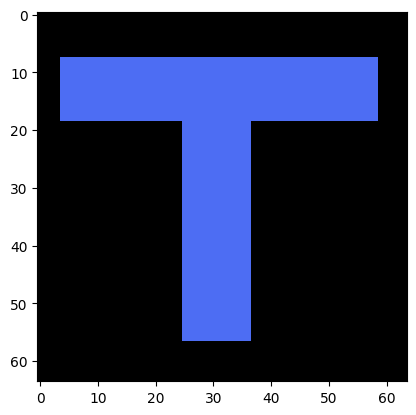

In [153]:
def load_target_image(image_path):
    # Load image with PIL
    img = Image.open(image_path).convert('RGBA')  # Ensure RGBA format
    # Define transformations: resize to 64x64, convert to tensor
    transform = transforms.Compose([
        transforms.Resize((GRID_SIZE, GRID_SIZE)),
        transforms.ToTensor()  # Converts to [4, 64, 64] (RGBA, [0,1])
    ])
    target = transform(img)  # [4, 64, 64]
    # Permute to [64, 64, 4] to match grid shape
    target = target.permute(1, 2, 0)
    return target

IMAGE_PATH="tum_t.png"
target = load_target_image(IMAGE_PATH)

fig, ax = plt.subplots() # figure for plotting
ax.imshow(target.detach().cpu().numpy()[:, :, :3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


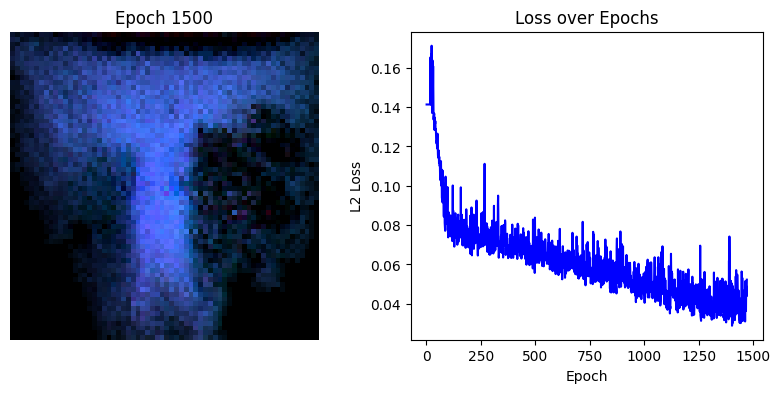

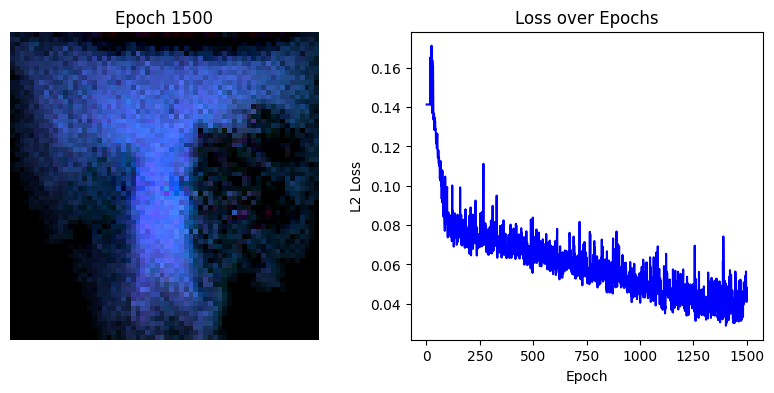

In [156]:
# time to run the training loop
EPOCHS=1500
PLOT_INTERVAL=30 # display live plot every n epochs
IMAGE_INTERVAL=10
training_loop(target=target, epochs=EPOCHS, plot_interval=PLOT_INTERVAL, image_interval=IMAGE_INTERVAL)

In [ ]:
from matplotlib.animation import FuncAnimation

def animate():
    fig, ax = plt.subplots()
    im = ax.imshow(grid_states[0], animated=True)
    ax.axis('off')
    
    epoch_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, color='white', 
                         fontsize=12, bbox=dict(facecolor='black', alpha=0.7))
    
    def update(frame):
        im.set_array(grid_states[frame])
        epoch_text.set_text(f'Epoch: {frame * IMAGE_INTERVAL}')  # +1 epoch for each animation step
        return [im, epoch_text]
    
    ani = FuncAnimation(fig, update, frames=len(grid_states), interval=50, blit=True)
    ani.save(f'nca_evolution_{EPOCHS}epochs_{CHANNELS}channels.gif', writer='pillow', fps=20)
    plt.close()

animate()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i